# Predicting sentiment from product reviews

## Constants

In [1]:
import pandas as pd
import bokeh
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

## Get Data

Loading reviews for a set of baby products. 

In [2]:
products = pd.read_csv("data/amazon_baby.csv")

Data includes the product name, the review text and the rating of the review. 

In [3]:
print(products.shape)
products.head(15)

(183531, 3)


,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5
6,A Tale of Baby\'s Days with Peter Rabbit,"Lovely book, it\'s bound tightly so you may no...",4
7,"Baby Tracker&reg; - Daily Childcare Journal, S...",Perfect for new parents. We were able to keep ...,5
8,"Baby Tracker&reg; - Daily Childcare Journal, S...",A friend of mine pinned this product on Pinter...,5
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4


### Basic exploration

##### Data types and Column names

In [4]:
products.dtypes

name      object
review    object
rating     int64
dtype: object

##### Total unique products

In [5]:
len(products.name.unique())

32418

##### Frequency count for each product

In [6]:
product_count = products.name.value_counts()
product_count[0:9]

Vulli Sophie the Giraffe Teether                                            785
Simple Wishes Hands-Free Breastpump Bra, Pink, XS-L                         562
Infant Optics DXR-5 2.4 GHz Digital Video Baby Monitor with Night Vision    561
Baby Einstein Take Along Tunes                                              547
Cloud b Twilight Constellation Night Light, Turtle                          520
Fisher-Price Booster Seat, Blue/Green/Gray                                  489
Fisher-Price Rainforest Jumperoo                                            450
Graco Nautilus 3-in-1 Car Seat, Matrix                                      419
Leachco Snoogle Total Body Pillow                                           388
Name: name, dtype: int64

##### Plotting the top 15 products based on number of reviews

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

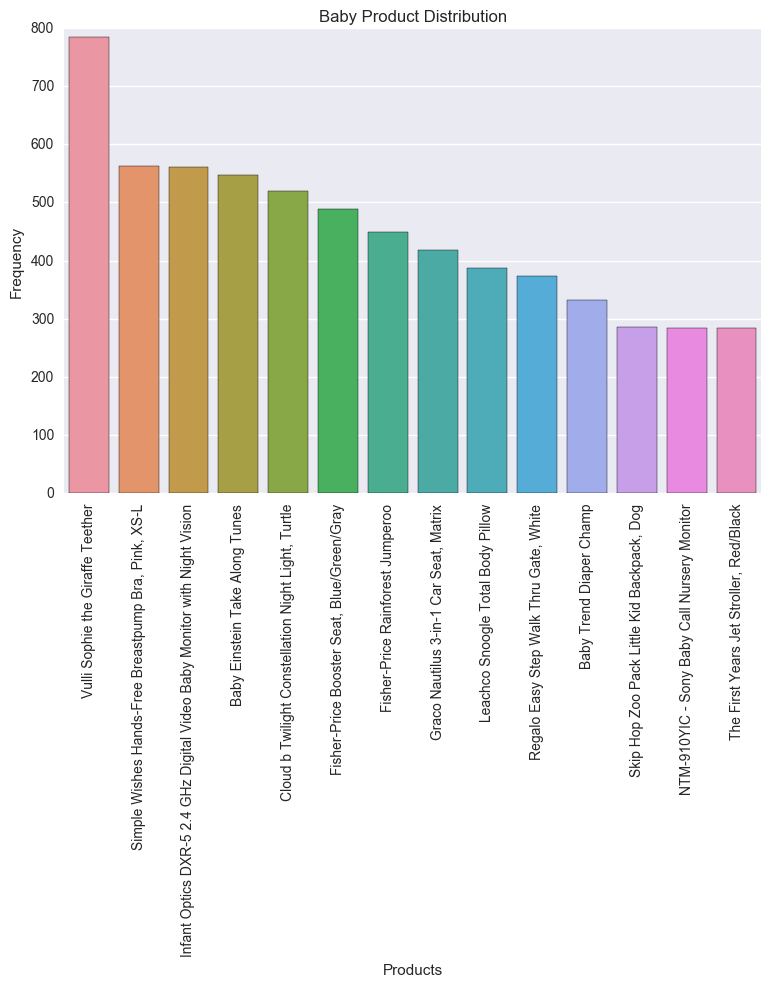

In [7]:
plt.figure(figsize=(9,6))
sns.barplot(x=product_count[0:14].index, y=product_count[0:14])
plt.title('Baby Product Distribution')
plt.xlabel('Products')
plt.ylabel('Frequency')
plt.xticks(rotation=90)

##### Examining the ratings distibution for top 15 products

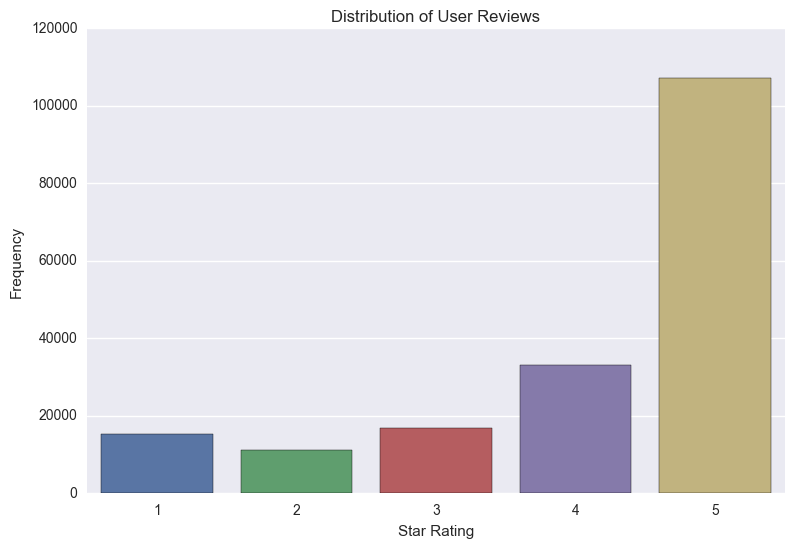

In [8]:
rating_count = products.rating.value_counts()
plt.figure(figsize=(9,6))
sns.barplot(x=rating_count[0:14].index, y=rating_count[0:14])
plt.title('Distribution of User Reviews')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')

##### Examining the ratings for most-reviewed product:  'Vulli Sophie the Giraffe Teether'

Product details as part of the lecture, hence no code for verification.

In [9]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']

In [10]:
giraffe_reviews['rating'].describe()

count    785.000000
mean       4.294268
std        1.227358
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64

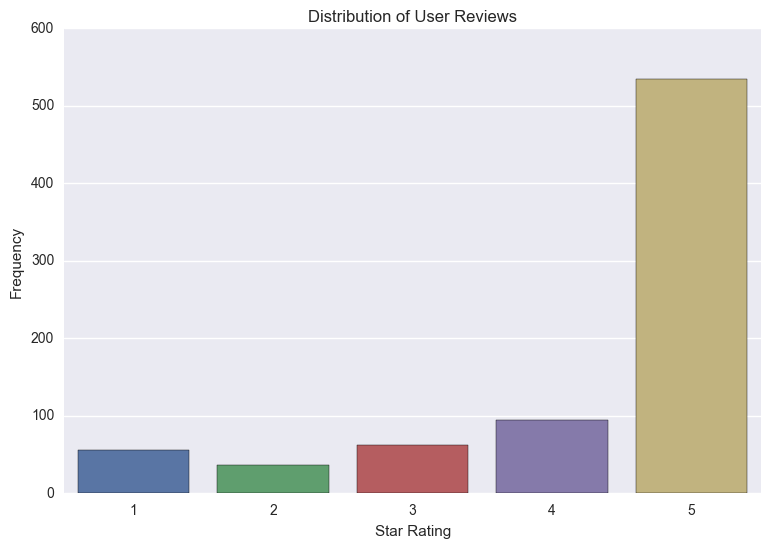

In [11]:
rating_count = giraffe_reviews.rating.value_counts()
plt.figure(figsize=(9,6))
sns.barplot(x=rating_count.index, y=rating_count)
plt.title('Distribution of User Reviews')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')

## Data Transformations

In [12]:
def string_to_dict(string):
    string = str(string)
    string = string.lower()
    wordlist = string.split()
    wordfreq = []
    for w in wordlist:
        wordfreq.append(wordlist.count(w))
    
    word_dict = dict(zip(wordlist, wordfreq))
    return(word_dict)

In [13]:
products["word_count"] = products["review"]
products["word_count"] = products["word_count"].apply(string_to_dict)

In [14]:
products.head()

,name,review,rating,word_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"{'6': 1, 'use': 1, 'softer': 1, 'just': 1, 'no..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'was': 1, 'now': 1, 'i': 1, 'and': 3, 'does':..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'quilt': 1, 'warmer': 1, 'for': 1, 'perfectly..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'i': 3, 'getting': 1, 'anything': 1, 'what': ..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'save': 1, 'i': 2, 'love\'s': 1, 'work': 1, '..."


## Build a sentiment classifier

##### Defining Sentiment

We will ignore all reviews with rating = 3 which in this case is considered neutral.  Reviews with a rating of 4 or higher will be considered positive or `True`, while the ones with rating of 2 or lower will have a negative sentiment (or `False`)   

In [15]:
#ignore all 3* reviews
products_non_neutral = products[products['rating'] != 3]
idx_length = products_non_neutral.rating.size
products_non_neutral.index = range(idx_length)

In [16]:
#positive sentiment = 4* or 5* reviews
products_non_neutral['sentiment'] = products_non_neutral['rating'] >=4

C:\Users\ouj070\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
products_non_neutral.head()

,name,review,rating,word_count,sentiment
0,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'was': 1, 'now': 1, 'i': 1, 'and': 3, 'does':...",True
1,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'quilt': 1, 'warmer': 1, 'for': 1, 'perfectly...",True
2,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'i': 3, 'getting': 1, 'anything': 1, 'what': ...",True
3,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'save': 1, 'i': 2, 'love\'s': 1, 'work': 1, '...",True
4,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'i': 1, 'does': 1, 'comes.': 1, 'using': 1, '...",True


## Quiz

### Transformations for Quiz

#### Setting up the selected words and features

In [18]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

In [19]:
def filtered_word_count(series_of_dicts, list_of_keys):
    """
    series_of_dicts must be a panda series where each record is a dictionary
    list_of_keys should be the list of keys that are needed to be retained
    
    both parameters are mandatory
    """
    idx = series_of_dicts.index
    iter = series_of_dicts.size
    selected_words_count = []
    for i in range(iter):
        old_dict = series_of_dicts[i]
        new_dict = {k: old_dict[k] for k in set(selected_words) & set(old_dict.keys())}
#         print(i)
        selected_words_count.append(new_dict)
    selected_words_count = pd.Series(selected_words_count)
    return (selected_words_count)

In [20]:
selected_words_count = filtered_word_count(products_non_neutral.word_count, list_of_keys=selected_words)

In [21]:
products_non_neutral["selected_words_count"] = selected_words_count

C:\Users\ouj070\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [22]:
products_non_neutral.head()

,name,review,rating,word_count,sentiment,selected_words_count
0,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{'was': 1, 'now': 1, 'i': 1, 'and': 3, 'does':...",True,{'love': 1}
1,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{'quilt': 1, 'warmer': 1, 'for': 1, 'perfectly...",True,{}
2,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{'i': 3, 'getting': 1, 'anything': 1, 'what': ...",True,{'love': 2}
3,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{'save': 1, 'i': 2, 'love\'s': 1, 'work': 1, '...",True,{'great': 1}
4,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{'i': 1, 'does': 1, 'comes.': 1, 'using': 1, '...",True,{'great': 1}


#### Featurizing the selected words

### Creating a classifier

##### Train, Test

In [23]:
random.seed(1234)
train_data,test_data = model_selection.train_test_split(products_non_neutral, test_size = 0.2)

In [24]:
print(train_data.shape)
test_data.shape

(133401, 6)


(33351, 6)